### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2022 ###


# Madison Bus Route Designing: Preliminary Report

Team Members: Rabeeya Hamid, Ai Guan, Naman Gupta

Data: 04/22/2022

*****

### Table of Contents

1. [Problem Description](#1.-Problem-Description)
2. [Data Collection](#2.-Data-Collection)
3. [Mathematical Model](#3.-Mathematical-Model)
4. [Preliminary Code Implementation](#4.-Code-Implementation)
5. [Preliminary Results and Analysis](#5.-Results-and-Analysis)


## 1. Problem Description


Based on the increasing need of public transportation, the City of Madison Metro Transit is proposing a major network redesign ([Transit Network Redesign](https://www.cityofmadison.com/metro/routes-schedules/transit-network-redesign)). Currently, they are surveying the students of UW-Madison and the residents of Madison for suggestions on their travel preferences, so that they can re-design the bus routes to meet the ridership demand and businesses. As University of Wisconsin-Madison students, our team thinks the redesign project would also have significant impact on our daily lives. 

The aim of the project is to model the routing design as a network optimization problem, so that we can propose the model as a part of their feedback survey. The family of network optimization problem includes assignment, critical path, max flow, shortest path, transportation, and min-cost flow problems. One of the primary results of the model is a network of arcs and nodes that illustrate the optimal routes for the nodes in a network ([Network Optimization](http://home.ubalt.edu/ntsbarsh/opre640a/partIII.htm#:~:text=The%20family%20of%20network%20optimization,called%20a%20vertex%2C%20or%20point)).

The project is a transportation problem in the network optimization problem family, and the nodes represent the bus stops, and the arcs represent the transportation flow between two stations. The model consist of three parts: decision variables, constraints, and objective function. We would like to model the optimal routes to meet the demand of ridership for each bus stop in Madison. Therefore, the objective function of the problem is to maximize the number of passengers boarding each bus on all the bus stops in Madison,  subject to fuel limitation of each bus, the capacity of a bus, routing regulations and ridership demand for each bus stop. 

## 2. Data Collection

The data utilized in the project is the publicly available data from the City of Madison website. Two datasets are selected corresponding to the 
   1.	Metro Transit Ridership by Stop | City of Madison Open Data.  [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-ridership-by-stop)
   2.	Metro Transit Bus Route Patterns | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-patterns/about)
   3.   Metro Transit Bus Stops | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/maps/metro-transit-bus-stops)
    
* The first dataset contains a list of all the bus stops, their geographical location (longitude and latitude) and the ridership at that bus stop averaged over 12 days. We do not have distances between these bus stops, nor do we have connections between them, for which we propose the following approach. 
   *   We calculate the Geodesic Euclidean distance between the geographic position of the bus stops to define the distances between them. 
   *   These distances will be multiplied by a constant of proportionality to determine the fuel cost associated with each path. 

* The second dataset contains a list of present bus routes, the bus stops along the routes and the total ridership for the bus routes averaged over 12 days. 
    
* The third dataset maps the bus stops to the bus routes taken by all the buses in Madison. 


Further, we load the data and map the bus routes to the bus stops and calculate the euclidean distance between each bus stop in Madison. We give a brief demo - 

In [2]:
import Pkg; 
Pkg.add("Cbc");
Pkg.add("GraphRecipes");
Pkg.add("LightGraphs");
Pkg.add("SimpleWeightedGraphs");
Pkg.add("SparseArrays");
Pkg.add("CSV");
Pkg.add("DataFrames");
Pkg.add("Geodesy");

using Pkg, JuMP, Plots, Cbc, GraphRecipes, LightGraphs, SimpleWeightedGraphs, SparseArrays;

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Qt5Base_jll ─ v5.15.3+1
  No Changes to `~/.julia/environments/v1.7/Project.toml`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [ea2cea3b] ↑ Qt5Base_jll v5.15.3+0 ⇒ v5.15.3+1
Precompiling project...
  ✓ Qt5Base_jll
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  4 dependencies successfully precompiled in 29 seconds (291 already precompiled, 3 skipped during auto due to previous errors)
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/envir

In [3]:
# Add packages
using Pkg

using CSV
using DataFrames

# import data set as a dataframe
ridership_data = CSV.read("data/Metro_Transit_Ridership_by_Stop.csv", DataFrame)
route_patterns_data = CSV.read("data/Metro_Transit_Bus_Route_Patterns.csv", DataFrame)
stops_data = CSV.read("data/Metro_Transit_Bus_Stops.csv", DataFrame);

In [4]:
first(ridership_data, 5)

,X,Y,OBJECTID,StopID,StopDescription,Lat,Lon
,Float64,Float64,Int64,Int64,String,Float64,Float64
1,-89.407,43.0711,10799,5,Dayton fs Orchard,43.0711,-89.407
2,-89.4002,43.0759,10800,10,Langdon ns Park,43.0759,-89.4002
3,-89.397,43.0758,10801,25,EB Langdon fs Lake,43.0758,-89.397
4,-89.3973,43.0718,10802,39,Lake ns Johnson,43.0718,-89.3973
5,-89.3901,43.0784,10803,45,EB Langdon ns Wisconsin,43.0784,-89.3901


In [5]:
first(route_patterns_data, 5)

,OBJECTID,PointsToLine_shape_id,PointsToLine_shape_id2,trips_routes_route_id
,Int64,Int64,Int64,Int64
1,3336,59757,59757,9899
2,3337,59758,59758,9899
3,3338,59759,59759,9899
4,3339,59761,59761,9899
5,3340,59763,59763,9899


In [6]:
first(stops_data, 5)

,X,Y,OBJECTID,stop_id,stop_code,stop_name,stop_desc
,Float64,Float64,Int64,Int64,String7,String,String
1,-89.3439,43.0907,28238,1191,1191,Oakridge & Miller (EB),This stop (#1191) is eastbound on the 2799 block of Oakridge Ave nearside Miller Ave
2,-89.3414,43.0909,28239,1386,1386,Oakridge & Maple (WB),This stop (#1386) is westbound on the 2998 block of Oakridge Ave farside Maple Ave
3,-89.3471,43.0905,28240,1457,1457,Oakridge & Evergreen (EB),This stop (#1457) is eastbound on the 2311 block of Oakridge Ave farside Evergreen Ave
4,-89.3435,43.0909,28241,1484,1484,Oakridge & Miller (WB),This stop (#1484) is westbound on the 2800 block of Oakridge Ave nearside Miller Ave
5,-89.3407,43.0908,28242,1519,1519,Oakridge & Maple (EB),This stop (#1519) is eastbound on the 2999 block of Oakridge Ave nearside Maple Ave


In [7]:
N = size(ridership_data,1)

2142

In [8]:
using Geodesy

stops = Vector{LatLon{Float64}}()

for i in eachrow(ridership_data)
    x = LatLon(i.Lat, i.Lon)
    push!(stops, x)
end

distances = zeros(N,N)

for i in 1:N
    for j in 1:N
        distances[i,j] = euclidean_distance(stops[i], stops[j])
    end
end


The distance between each bus stop in Madison as a $n * n$ matrix.

In [9]:
distances

2142×2142 Matrix{Float64}:
     0.0      770.656    974.321   …  9116.76   11031.0     9974.57
   770.656      0.0      263.84       8351.56   10264.0     9210.79
   974.321    263.84       0.0        8145.92   10062.1     9002.55
   794.924    510.88     447.575      8449.38   10371.2     9299.83
  1602.09     872.171    630.145      7529.52    9448.51    8383.84
   611.097   1026.19    1287.46    …  9260.55   11159.1    10125.3
   939.284    239.555     35.5769     8181.38   10097.7     9037.96
   412.952    745.492    845.271      8945.64   10866.5     9797.28
   567.934    439.384    703.178      8694.74   10599.6     9557.52
   593.444    290.538    554.285      8587.94   10495.9     9449.46
   317.611    779.899    908.545   …  9030.56   10950.4     9883.46
   618.466    560.763    823.197      8754.44   10655.7     9618.47
   606.094    275.601    539.429      8571.96   10480.0     9433.44
     ⋮                             ⋱                ⋮      
 12189.1    11418.5    11231.5

We map the bus stops (ids) to bus routes  that will help us model the optimal bus routes.

In [10]:
stop_route = Dict()

for i in eachrow(stops_data)
    if i.Route != "None"
        stop_route[i.stop_id] = i.Route
    end
end

stop_route

Dict{Any, Any} with 1744 entries:
  9167 => "30"
  7144 => "16, 31, 38"
  9140 => "36"
  8690 => "55"
  4522 => "49"
  4838 => "75"
  7538 => "39"
  1812 => "5, 28"
  1199 => "6, 15"
  5143 => "21"
  7272 => "38"
  8363 => "51"
  7766 => "32"
  1704 => "5, 28"
  4876 => "18, 40"
  9675 => "20"
  2398 => "8, 38, 78"
  6785 => "70, 78"
  1823 => "4, 7, 38"
  6652 => "72"
  694  => "44"
  4623 => "75"
  692  => "2, 28, 48"
  2119 => "7"
  6430 => "68, 73"
  ⋮    => ⋮

## 3. Mathematical Model

For the preliminary report, our focus is to generate an illustrative demo of the model. It is a smaller bus network which consists of 8 bus stations.

### Parameters Given:
- Number of bus stops ```n``` : number of nodes in our network
- Adjacency Matrix ```Adj``` ($n \times n$) : describes connections between bus stops
- Distance Matrix ```D``` ($n \times n$): Euclidean distances between all bus stops
- Ridership vector ```r```($n \times 1$): the ridership demand at every bus stop
- Start node ```n_i```: the bus stop from where our bus starts
- End node ```n_e```: the bus stop where our bus route ends
- Distance (Fuel) limit ```f```: the distance our bus can travel in total

In [14]:
n = 8

Adj = [0 0 0 0 1 0 1 0;
       0 0 1 0 0 1 0 0;
       1 0 0 0 0 0 1 0;
       0 0 0 0 1 0 0 1;
       0 0 0 0 0 0 1 0;
       0 0 0 1 0 0 0 1;
       0 0 0 0 0 0 0 0;
       1 0 0 1 0 0 1 0;]

D = [0 4 6 3 10 1 8 10;
     5 0 2 6 5 5 4 6;
     1 8 0 4 2 7 2 3;
     7 2 3 0 4 2 8 9;
     2 3 9 4 0 5 1 2;
     1 4 1 3 10 0 8 8;
     5 8 2 6 5 2 0 6;
     1 8 7 4 2 1 2 0]

r = [4, 1, 8, 2, 9, 10, 5, 8]

n_i = 2
n_e = 7

f = 20
;

### Plotting network:

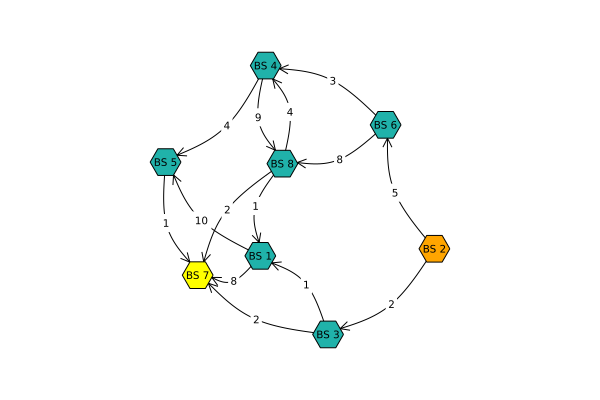

In [15]:
edgelabel_dict = Dict()
for i in 1:n
    for j in 1:n
        edgelabel_dict[(i, j)] = D[i, j]
    end
end

membership = [1,2,1,1,1,1,3,1]
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"yellow"]
# membership color
nodefillc = nodecolor[membership]

graph = graphplot(Adj, names="BS ".*string.(1:n), curvature_scalar=0.06, edgelabel=edgelabel_dict, markercolor=nodefillc)

## _Orange: Start node <br> Yellow: End node_

## _Ridership_: 
**BS 1: 4 <br> BS 2: 1 <br> BS 3: 8 <br> BS 4: 2 <br> BS 5: 9 <br> BS 6: 10 <br> BS 7: 5 <br> BS 8: 8 <br>**

### Parameters Calculated:
- Number of paths ```e```: number of edges in our network 
- Incidence matrix ```Inc```($n \times e$): describes the edges in our network.
- Edge costs ```d_e```($e \times 1$): the distance corresponding to edges in the network
- Rider intake ```r_e```($e \times 1$): the riders taken up after traveling to each edge
- Flow vector ```b``` ($n \times 1$): includes the start and end node

### Function for incidence matrix:
Defining function to calculate incidence matrix from adjacency matrix, taken from: https://github.com/sbromberger/LightGraphs.jl/issues/1489

In [16]:
function my_incidence_matrix(G)
    I = vcat([src(e) for e in edges(G)], [dst(e) for e in edges(G)])
    J = vcat(collect(1:ne(G)), collect(1:ne(G)))
    V = vcat(fill(-1, ne(G)), fill(1, ne(G)))
    return sparse(I, J, V)
end
;

### Calculating incidence matrix and number of edges:

In [17]:
dirGraph = LightGraphs.DiGraph(Adj) # converting adjacency matrix into a directed graph

Inc = Array(my_incidence_matrix(dirGraph)) # converting directed graph to an incidence matrix

e = size(Inc)[2] # number of edges
;

### Defining edge costs, rider intake, and flow vector:

In [18]:
temp_D = D.*Adj
temp_r = zeros((n,n))

for i = 1:n
        temp_r[i, :] = r.*Adj[i, :]
end

d_e = zeros(0)
r_e = zeros(0)

for i = 1:n
    for j = 1:n
        if temp_D[i, j] != 0
            append!(d_e, temp_D[i, j])
        end
        if temp_r[i, j] != 0
            append!(r_e, temp_r[i, j])
        end
    end    
end

b = zeros(n)
b[n_i] = -1
b[n_e] = 1
;


**Decision variable:** <br>

$x$: all possible edges in the network, length = $e$ <br>
    $$ x =   \left\{
\begin{array}{ll}
      1 & \text{If the bus travels on that edge}  \\
      0 & \text{If the bus doesn NOT travel on that edge} \\
\end{array} 
\right.  $$

**Objective function:** <br>
$$ \max_{x} \text{    }r_e \cdot x$$

**Constraints:** <br>
  s.t. 
$$ \text{Inc}*x = b, $$
$$ d_e \cdot x <= f  $$


## 4. Code Implementation

In [20]:
using LinearAlgebra

bus_route = Model(with_optimizer(Cbc.Optimizer,loglevel=0))

@variable(bus_route, x[1:e], Bin) # binary decision variable x that maps out the [ath]
@constraint(bus_route, Inc*x .== b) # nodal conservation
@constraint(bus_route, dot(d_e, x) <= f) # fuel constraint

@objective(bus_route, Max, dot(r_e, x))  # maximize people getting on the bus
    
optimize!(bus_route)

## 5. Results and Analysis

### Defining dictionary for converting edge index to path:

In [21]:
edgeIndex2path = Dict()
count = 1
for i = 1:n
    for j = 1:n
        if Adj[i, j] != 0
            edgeIndex2path[count] = (i, j)
            count = count + 1
        end
    end
end

### Finding the optimal path taken:

In [22]:
opt_path = value.(x)

# finding edges travelled using edgeIndex2path dictionary
path_taken_x = zeros(0)
path_taken_y = zeros(0)
for i = 1:e
    if opt_path[i] != 0
        temp = edgeIndex2path[i]
        append!(path_taken_x, temp[1] )
        append!(path_taken_y, temp[2] )
    end
end

# defining dictionary with 1 for travelled edges, 0 for untravelled edges
travelled_edges_dict = Dict()
for k = 1:length(path_taken_x)
    for i in 1:n
        for j in 1:n
            if i == path_taken_x[k] && j == path_taken_y[k] 
                travelled_edges_dict[(i, j)] = 1
            elseif haskey(travelled_edges_dict, (i, j))
                if travelled_edges_dict[(i, j)] == 1
                    travelled_edges_dict[(i, j)] = 1
                end
            else 
                travelled_edges_dict[(i, j)] = 0
            end
        end
    end
end

# printing the edges travelled on

print("The bus travelled on these edges: \n")
for i = 1:n
    for j = 1:n
        if travelled_edges_dict[(i, j)] != 0
            println((i, j))
        end
    end
end

The bus travelled on these edges: 
(1, 5)
(2, 3)
(3, 1)
(5, 7)


We can see that the bus travels from 2 to 7 twice!  

In the future work, we plan to fix this issue by adding another constraint that allows the bus to travel only once along the route.

### Finding nodes travelled:

In [23]:
nodes = 1:n

temp_path = zeros((n,n))

# defining temporary variable temp_path to store nodes travelled to for on each edge index
# (zeros need to be filtered out) 
for i = 1:n
        temp_path[i, :] = nodes.*Adj[i, :]
end

path = zeros(0)

# filtering out zeros
for i = 1:n
    for j = 1:n
        if temp_path[i, j] != 0
            append!(path, temp_path[i, j])
        end
    end    
end


# finding actual nodes travelled to using optimal edge vector x
temp_path = path.*opt_path

path = zeros(0)

# filtering out zeros again
for p in temp_path
    if p != 0
        append!(path, p)
    end
end

# defining membership based on nodes travelled to, 1 for not travelled to, 2 for travelled to
membership = ones(n)
for i = 1:n
    for p in path 
        if p == i
            membership[i] = 2
        end
    end
end

# start node is also travelled to 
membership[n_i] = 2

# convert to int for indexing
for i = 1:n
    membership[i] = convert(Int, membership[i])
end

# assigning colours, yellow for travelled to, seagreen for not
int_membership = Int.(membership)
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"yellow"]
nodefillc = nodecolor[int_membership]
;

### Plotting final network:
Yellow bus stops: are included in route
Seagreen bus stops: are NOT included in route
Paths with 1: are included in route
Paths with 0: are NOT included in route

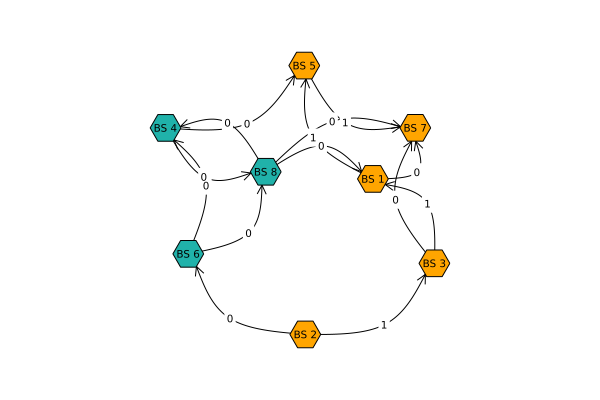

In [24]:
# edges are 1 for travelled on, 0 for not travelled on
graph = graphplot(Adj, names="BS ".*string.(1:n), curvature_scalar=0.11, edgelabel=travelled_edges_dict, markercolor=nodefillc)


The bus travelled on these edges: 
(1, 5)
(2, 3)
(3, 1)
(5, 7)

### Fuel used, and people picked up:

In [26]:
println("Fuel used: ", dot(d_e, opt_path))
println("People picked up: ", dot(r_e, opt_path) + r[n_i]) 

Fuel used: 14.0
People picked up: 27.0


# Next Steps

Next, we will work on improving the mathematic model and show the solution to the optimization problem via suitable plots. 

* **Merge the optimization model with bus data**: We will further analyze the real bus network of Madison and utilize the full dataset of Madison metro transit to develop the model.  

* **Include reasonable estimations of unknown constraint variables**: We will include estimates of fuel value (considering the distances matrix), start and end nodes (considering the network map). 

* **Run X different buses simultaneously**: We will run X (around ~three) different buses simultaneously in the Madison bus system. We will ideally want that these bus routes do not overlap (or try and minimize overlap).

* **Cycle constraint**: We want to make sure that no cycles exists in the network, for this we will have to add a constraint such that no bus travels on the same edge/path twice.

* **Bus capacity constraint**: Currently we're assuming that the number of people entering and leaving the bus are always equal so we aren't taking into account bus capacity, and we aren't keeping track of passengers at evert bus stop. It will be interesting to see if we can implement a probability function for people leaving at a bus stop, and then use that to place a limit on the bus capacity. Which will limit the number of people we can take up at each bus stop. 

* **Sensitvity analysis:** Once we have our final results, we want to do a sensitivity analysis to analyze the fuel and capacity constraints.  